In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import numpy as np

import statsmodels.api as sm

from tqdm import tqdm
from pathlib import Path

from concurrent.futures import ThreadPoolExecutor
from tqdm import trange, tqdm
import numpy as np
import pandas as pd

# import seaborn as sns

# current_path = sys.path[0]
# sys.path.append(current_path[: current_path.find("defi-measurement")] + "liquidity-distribution-history")

# sys.path.append("..")

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D


import polars as pl


# Adjust so all columns in dataframe are shown
pl.Config.set_tbl_cols(-1)
pl.Config.set_tbl_width_chars(1000)


# Adjust so all columns in dataframe are shown
pd.set_option("display.max_columns", None)

# Set pandas display options column width
pd.set_option("display.max_colwidth", 1000)

In [3]:
plot_base_path = Path("./Figures")

# This path is for the presentation at NeurIPS 2023
# plot_base_path = Path(
#     "/Users/larsankile/Library/CloudStorage/GoogleDrive-lars.ankile@gmail.com/My Drive/10 – Harvard/Summer 2023/NeurIPS Presentation/Figures"
# )

data_base_path = Path(".").absolute().parent.parent / "data_original"

# plot_file_type = ".pdf"
plot_file_type = ".png"

save_plots = False

metrics = ["metric_l1", "metric_l2", "metric_linf"]
metrics_latex = ["$\\bar{S}_1$", "$\\bar{S}_2$", "$\\bar{S}_\\infty$"]

scores = ["score_l1", "score_l2", "score_linf"]
scores_latex = ["$S_1$", "$S_2$", "$S_\\infty$"]

## Get data


In [4]:
# count: int = int(
#     pd.read_sql_query(
#         """
#     SELECT
#         COUNT(*) as cnt
#     FROM
#         block_pool_metrics
#     """,
#         postgres_uri,
#         dtype={"cnt": int},
#     )
#     .iloc[0]
#     .cnt
# )

# Use polars and parquet files instead now
df = pl.read_parquet(
    data_base_path / "pool_block_metrics_original/*.parquet"
).to_pandas()

count = df.shape[0]

f"Total number of rows: {count:,}"

'Total number of rows: 447,000'

In [5]:
df.columns

Index(['block_number', 'pool_address', 'num_transactions', 'n_buys', 'n_sells',
       'baseline_price', 'created_at', 'mev_boost', 'mev_boost_amount',
       'realized_order', 'realized_prices', 'realized_l1', 'realized_l2',
       'realized_linf', 'volume_heur_order', 'volume_heur_prices',
       'volume_heur_l1', 'volume_heur_l2', 'volume_heur_linf', 'tstar_l1',
       'tstar_l2', 'tstar_linf'],
      dtype='object')

In [6]:
# if "df" in locals() and locals()["df"].shape[0] == count:
#     print("Dataframe already loaded")
# else:
#     chunksize = 10_000

#     dfs = pd.read_sql_query(
#         """
#         SELECT
#             *
#         FROM
#             block_pool_metrics
#         """,
#         postgres_uri,
#         chunksize=chunksize,
#     )

#     df = pd.concat(tqdm(dfs, total=math.ceil(count / chunksize)))

In [7]:
# min_max_date = pd.read_sql_query(
#     f"""
#     SELECT
#         block_ts
#     FROM
#         block_info
#     WHERE
#         block_number = {df.block_number.min()}
#     OR block_number = {df.block_number.max()}
#     """,
#     postgres_uri,
# )

# min_date = min_max_date.iloc[0].block_ts
# max_date = min_max_date.iloc[1].block_ts

# Use polars and parquet files instead now
min_block = df.block_number.min().item()
max_block = df.block_number.max().item()

f"Min block number: {min_block}, Max block number: {max_block}"

'Min block number: 15537940, Max block number: 17959799'

In [8]:
# print(f"First block: {df.block_number.min()} ({min_date}), Last block: {df.block_number.max()} ({max_date})")
# df.head()

## Descriptive statistics


### Number of swaps in each pool-block pair


In [9]:
count_df = df.groupby("num_transactions").block_number.count().sort_index()
count_df = count_df[count_df.index < 50]
counts: np.ndarray = count_df.to_numpy()
index = count_df.index.to_numpy()

print(counts)
print(index)


# count_df = df.group_by("num_transactions").agg(pl.count("block_number")).sort("num_transactions")
# count_df = count_df.filter(pl.col("num_transactions") < 50)

# counts = count_df.select("block_number").to_numpy().squeeze()
# num_transactions = count_df.select("num_transactions").to_numpy().squeeze()

# count_df

[411008  32565   2966    390     49     16      3      3]
[1 2 3 4 5 6 7 8]


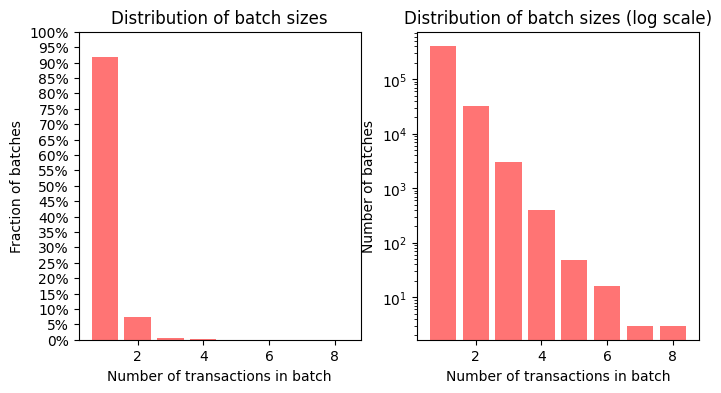

In [10]:
normalized = counts / counts.sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

bar_col = "#FF7474"

ax1.bar(index, normalized, color=bar_col)
ax1.set_xlabel("Number of transactions in batch")
ax1.set_ylabel("Fraction of batches")
ax1.set_title("Distribution of batch sizes")
ax1.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax1.set_yticks(np.arange(0, 1.05, 0.05))

ax2.bar(index, counts, color=bar_col)
ax2.set_yscale("log")
ax2.set_xlabel("Number of transactions in batch")
ax2.set_ylabel("Number of batches")
ax2.set_title("Distribution of batch sizes (log scale)")

# Save plot
if save_plots:
    fig.tight_layout()
    fig.savefig(
        str(plot_base_path / "descriptive" / f"transactions_per_block{plot_file_type}")
    )

### Number of blocks, min and max block number, total number of swaps, and total number of pools


In [11]:
print(f"There are {len(df):,} batches in the database")
print(f"There are {df.block_number.nunique():,} unique blocks in the database")
print(f"First block: {df.block_number.min():,}, last block: {df.block_number.max():,}")
print(f"Total number of transactions: {df.num_transactions.sum():,}")
print(f"There are {df.pool_address.nunique():,} unique pools in the database")

There are 447,000 batches in the database
There are 277,955 unique blocks in the database
First block: 15,537,940, last block: 17,959,799
Total number of transactions: 486,982
There are 80 unique pools in the database


### Share of blocks, swaps, and pools created through MEV-boost auctions


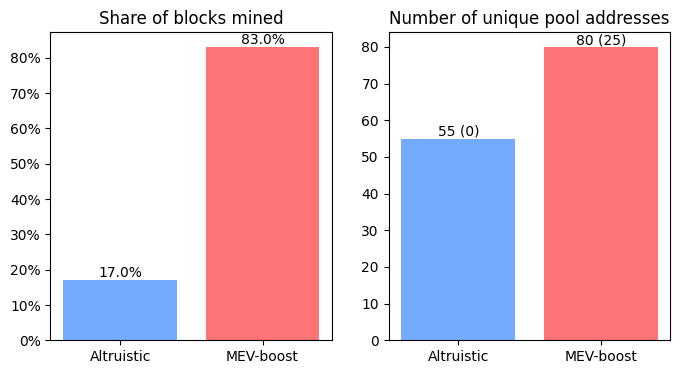

In [12]:
# Plot setup
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
bar_cols = ["#74ABFF", "#FF7474", "#F3DAFF"]

# First plot
block_share = df.groupby("mev_boost").block_number.nunique().sort_index()
bars = ax1.bar(
    ["Altruistic", "MEV-boost"], block_share.values / block_share.sum(), color=bar_cols
)
ax1.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

# Add the values atop the bars
for bar in bars:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        "{:.1%}".format(height),
        ha="center",
        va="bottom",
    )

ax1.set_title("Share of blocks mined")

# Second plot
pool_count = df.groupby("mev_boost").pool_address.nunique().sort_index()
bars = ax2.bar(["Altruistic", "MEV-boost"], pool_count.values, color=bar_cols)

only_altruistic = set(df[df.mev_boost == False].pool_address.unique())
only_mev = set(df[df.mev_boost == True].pool_address.unique())
only_altruistic_count = len(only_altruistic - only_mev)
only_mev_count = len(only_mev - only_altruistic)

# Add the values atop the bars
for bar, only in zip(bars, [only_altruistic_count, only_mev_count]):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height} ({only})",
        ha="center",
        va="bottom",
    )

ax2.set_title("Number of unique pool addresses")

# Save plot
if save_plots:
    fig.tight_layout()
    fig.savefig(str(plot_base_path / "descriptive" / f"blocks_mined{plot_file_type}"))

In [13]:
def get_p_value(sums, counts):
    # Assuming group1 and group2 are the two groups with binary values (0 or 1)
    count1 = sums.loc[False]
    count2 = sums.loc[True]
    n1 = counts.loc[False]
    n2 = counts.loc[True]

    _, p_value = sm.stats.proportions_ztest([count1, count2], [n1, n2])

    return p_value

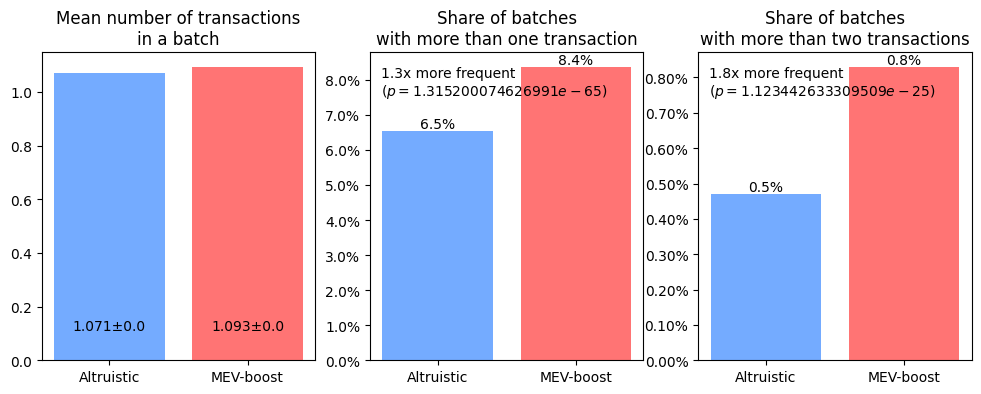

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# First plot
n_transaction_mean = df.groupby("mev_boost").num_transactions.mean().sort_index()
n_transaction_std = df.groupby("mev_boost").num_transactions.std().sort_index()
n_transaction_sem = df.groupby("mev_boost").num_transactions.sem().sort_index()

bars = ax1.bar(
    ["Altruistic", "MEV-boost"],
    n_transaction_mean.values,
    color=bar_cols,
    yerr=n_transaction_sem.values,
)

# Add the values at the base of the bars
for bar, mean, std in zip(bars, n_transaction_mean.values, n_transaction_sem.values):
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        0.1,
        f"{mean:.3f}±{std:.1f}",
        ha="center",
        va="bottom",
    )

ax1.set_title("Mean number of transactions\nin a batch")

# Second plot
share_more_than_one_mean = (
    df.assign(more_than_one=df.num_transactions > 1)
    .groupby("mev_boost")
    .more_than_one.mean()
    .sort_index()
)
sum_more_than_one = (
    df.assign(more_than_one=df.num_transactions > 1)
    .groupby("mev_boost")
    .more_than_one.sum()
    .sort_index()
)
count_more_than_one = (
    df.assign(more_than_one=df.num_transactions > 1)
    .groupby("mev_boost")
    .more_than_one.count()
    .sort_index()
)
p_value = get_p_value(sum_more_than_one, count_more_than_one)

bars = ax2.bar(
    ["Altruistic", "MEV-boost"], share_more_than_one_mean.values, color=bar_cols
)
ax2.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

# Add the values atop the bars
for bar in bars:
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        "{:.1%}".format(height),
        ha="center",
        va="bottom",
    )

ax2.set_title("Share of batches\nwith more than one transaction")

# Add text saying how many times more frequent it is in the MEV-boosted blocks
x_more_freq = share_more_than_one_mean.values[1] / share_more_than_one_mean.values[0]
ax2.text(
    0.04,
    0.9,
    f"{x_more_freq:.1f}x more frequent\n($p={p_value}$)",
    ha="left",
    va="center",
    transform=ax2.transAxes,
)

# Third plot
share_more_than_two_mean = (
    df.assign(more_than_two=df.num_transactions > 2)
    .groupby("mev_boost")
    .more_than_two.mean()
    .sort_index()
)
sum_more_than_two = (
    df.assign(more_than_two=df.num_transactions > 2)
    .groupby("mev_boost")
    .more_than_two.sum()
    .sort_index()
)
count_more_than_two = (
    df.assign(more_than_two=df.num_transactions > 2)
    .groupby("mev_boost")
    .more_than_two.count()
    .sort_index()
)
p_value = get_p_value(sum_more_than_two, count_more_than_two)

bars = ax3.bar(
    ["Altruistic", "MEV-boost"], share_more_than_two_mean.values, color=bar_cols
)
ax3.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

# Add the values atop the bars
for bar in bars:
    height = bar.get_height()
    ax3.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        "{:.1%}".format(height),
        ha="center",
        va="bottom",
    )

ax3.set_title("Share of batches\nwith more than two transactions")

# Add text saying how many times more frequent it is in the MEV-boosted blocks
x_more_freq = share_more_than_two_mean.values[1] / share_more_than_two_mean.values[0]
ax3.text(
    0.04,
    0.9,
    f"{x_more_freq:.1f}x more frequent\n($p={p_value}$)",
    ha="left",
    va="center",
    transform=ax3.transAxes,
)

# Save plot
if save_plots:
    fig.tight_layout()
    fig.savefig(
        str(plot_base_path / "empirical" / f"transactions_per_block{plot_file_type}")
    )

In [15]:
from scipy.stats import ttest_ind

# Split the data into two groups based on MEV-boost (true/false)
group1 = df[df["mev_boost"] == True]["num_transactions"]
group2 = df[df["mev_boost"] == False]["num_transactions"]

# Perform the two-sample t-test
t_stat, p_value = ttest_ind(group1, group2)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:3e}")

T-statistic: 17.965
P-value: 3.899895e-72


## Statistics on the Metric


In [16]:
df_metric = df.assign(
    metric_l1=df.realized_l1 / df.volume_heur_l1 - 1,
    metric_l2=df.realized_l2 / df.volume_heur_l2 - 1,
    metric_linf=df.realized_linf / df.volume_heur_linf - 1,
)


# Take out extreme outliers
outlier_thresh = 1e1
cnt_before = len(df_metric)
df_metric = df_metric[
    (df_metric.metric_l1 < outlier_thresh) & ((df_metric.metric_l1 >= 0))
]
cnt_after = len(df_metric)
print(
    f"Removed {cnt_before - cnt_after} outliers ({(cnt_before - cnt_after) / cnt_before:.3%})"
)

df_metric_1 = df_metric[df_metric.num_transactions > 1]
df_metric_2 = df_metric[df_metric.num_transactions > 2]

# df_metric.head()
df_metric_2.head()

Removed 231 outliers (0.052%)


,block_number,pool_address,num_transactions,n_buys,n_sells,baseline_price,created_at,mev_boost,mev_boost_amount,realized_order,realized_prices,realized_l1,realized_l2,realized_linf,volume_heur_order,volume_heur_prices,volume_heur_l1,volume_heur_l2,volume_heur_linf,tstar_l1,tstar_l2,tstar_linf,metric_l1,metric_l2,metric_linf
261,17345168,0x01bbf165ae1c7ca106f8a10d0d3c25b50475e53f,3,0,3,1.112530e+09,2024-08-06 00:10:07.136902,True,0.068910,"043_684,106_789,110_806","1112459885.2962444,1105526135.867478,1105066192.5580754",1.453644e+07,1.023496e+07,7.463359e+06,"043_684,110_806,106_789","1112459885.2962444,1111995608.5850897,1105066192.5580754",8.066969e+06,7.482759e+06,7.463359e+06,8.066969e+06,7.482759e+06,7.463359e+06,0.801971,0.367806,0.000000
1073,16537830,0x020c349a0541d76c16f501abc6b2e9c98adae892,3,1,2,2.655966e+00,2024-08-06 00:10:19.838803,True,0.397569,"001_036,003_054,003_054","2.786611432453432,2.747963030389088,2.7104475959216705",2.771254e-01,1.688199e-01,1.306459e-01,"003_054,001_036,003_054","2.6418868293616753,2.7496873200467595,2.7121366906929523",1.639716e-01,1.101689e-01,9.372177e-02,8.930006e-02,6.197225e-02,5.777530e-02,0.690081,0.532375,0.393976
2645,16745937,0x04916039b1f59d9745bf6e0a21f191d1e0a84287,3,1,2,1.444124e-01,2024-08-06 00:11:45.862249,True,0.063219,"000_002,001_016,003_032","0.1436623822754721,0.14131481300429727,0.14261512717942254",5.644938e-03,3.658960e-03,3.097607e-03,"000_002,003_032,001_016","0.1436623822754721,0.14497411438432511,0.14259572649356803",3.128426e-03,2.044122e-03,1.816694e-03,3.128426e-03,2.044122e-03,1.816694e-03,0.804402,0.789991,0.705079
2740,16813613,0x04916039b1f59d9745bf6e0a21f191d1e0a84287,3,1,2,2.032734e-01,2024-08-06 00:11:50.617555,True,0.122725,"006_026,007_032,008_035","0.2023899309417903,0.19826622747613035,0.19915019531740222",1.001395e-02,6.546280e-03,5.007206e-03,"006_026,008_035,007_032","0.2023899309417903,0.20328148426557532,0.1991316200022442",5.033367e-03,4.235004e-03,4.141813e-03,5.033367e-03,4.235004e-03,4.141813e-03,0.989513,0.545755,0.208940
2765,16836075,0x04916039b1f59d9745bf6e0a21f191d1e0a84287,3,1,2,2.015753e-01,2024-08-06 00:11:52.056350,True,0.035676,"003_011,005_035,006_048","0.19394493102948987,0.1925950363953495,0.20017456105851364",1.801131e-02,1.186714e-02,8.980244e-03,"005_035,006_048,003_011","0.20014357917809317,0.2078713949811651,0.19988418970577412",9.418906e-03,6.674625e-03,6.296115e-03,9.104691e-03,6.674625e-03,6.296115e-03,0.912251,0.777949,0.426315


### Metric Sanity Check


In [17]:
# Define the metrics to compare
realized_metrics = ["realized_l1", "realized_l2", "realized_linf"]
volume_metrics = ["volume_heur_l1", "volume_heur_l2", "volume_heur_linf"]
tstar_metrics = ["tstar_l1", "tstar_l2", "tstar_linf"]

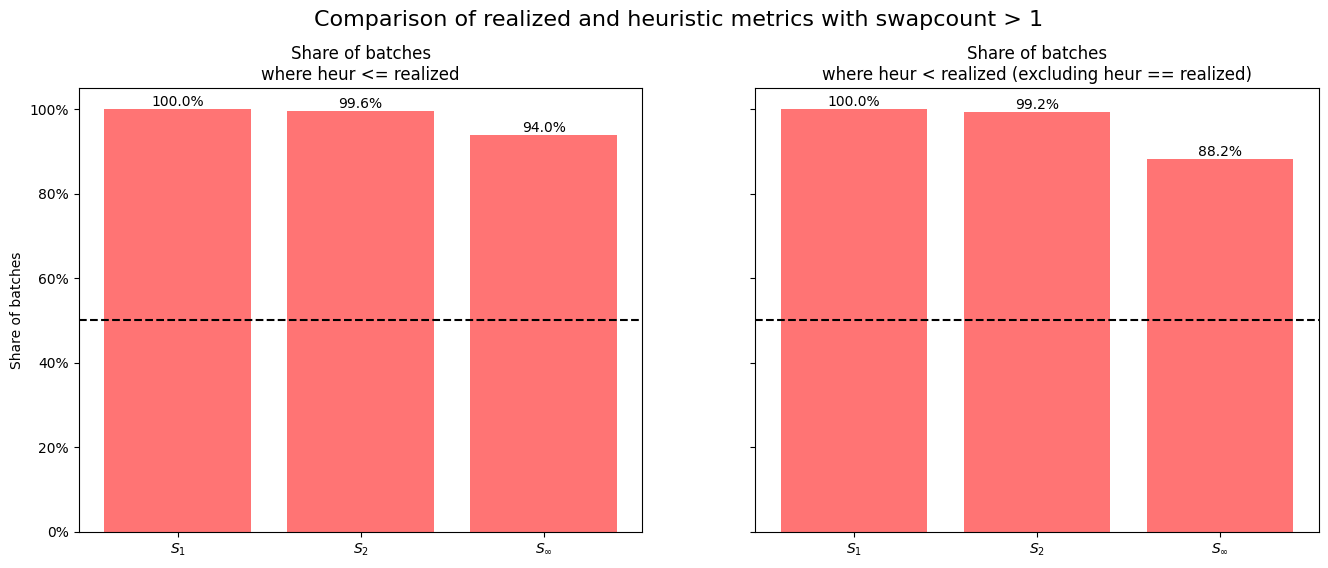

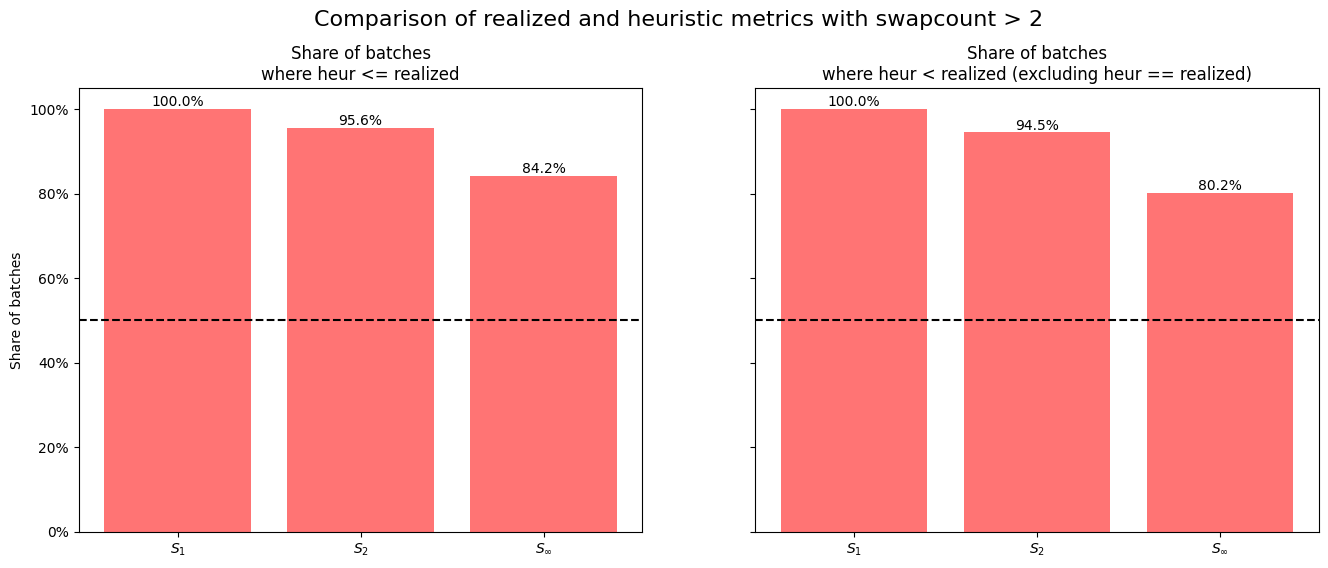

In [18]:
def plot_metric_comparison(df, ax1, ax2):
    differences = df[realized_metrics].values - df[volume_metrics].values

    diff_df = pd.DataFrame(differences, columns=scores)
    diff_df_no_zeros = diff_df[(diff_df != 0).all(1)]

    col_labels = diff_df.columns.map(lambda score: scores_latex[scores.index(score)])

    # Plot the rate each metric is positive
    bars = ax1.bar(x=col_labels, height=(diff_df >= 0).mean(), color=bar_cols[1])

    ax1.set_title("Share of batches\nwhere heur <= realized")
    ax1.set_ylabel("Share of batches")
    ax1.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

    # Add the values atop the bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            "{:.1%}".format(height),
            ha="center",
            va="bottom",
        )

    # Add horizontal line at 50%
    ax1.axhline(0.5, color="black", linestyle="--")

    bars = ax2.bar(
        x=col_labels,
        height=(diff_df_no_zeros >= 0).mean(),
        color=bar_cols[1],
    )

    ax2.set_title(
        "Share of batches\nwhere heur < realized (excluding heur == realized)"
    )
    ax2.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

    # Add the values atop the bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            "{:.1%}".format(height),
            ha="center",
            va="bottom",
        )

    # Add horizontal line at 50%
    ax2.axhline(0.5, color="black", linestyle="--")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplots_adjust(top=0.85)
fig.suptitle(
    "Comparison of realized and heuristic metrics with swapcount > 1", fontsize=16
)
plot_metric_comparison(df_metric_1, ax1, ax2)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplots_adjust(top=0.85)
fig.suptitle(
    "Comparison of realized and heuristic metrics with swapcount > 2", fontsize=16
)
plot_metric_comparison(df_metric_2, ax1, ax2)

### Heuristic $\widehat{T}^*$ vs. $T^*$

The below shows that in 85 % of cases where the realized order is worse than the optimal order, the heuristic is equal to the optimal order.


In [19]:
assert (
    False
), "We need to ensure we handle the case where T^* is not computed and has the value math.inf"

df1 = df_metric[
    (df_metric.tstar_l1 != 0) & (df_metric.realized_l1 != df_metric.tstar_l1)
]

heur_rel = pd.DataFrame(
    df1[volume_metrics].to_numpy() / df1[tstar_metrics].to_numpy(), columns=scores
)
heur_rel = heur_rel[heur_rel.score_l1 < 1e1]

print(
    f"{(heur_rel.score_l1 == 1).mean():.1%} of batches have heur == T*, mean heur / T* = {heur_rel.score_l1.mean():.2f}"
)
print(
    f"{(heur_rel.score_l2 == 1).mean():.1%} of batches have heur == T*, mean heur / T* = {heur_rel.score_l2.mean():.2f}"
)
print(
    f"{(heur_rel.score_linf == 1).mean():.1%} of batches have heur == T*, mean heur / T* = {heur_rel.score_linf.mean():.2f}"
)

fig, ax = plt.subplots(figsize=(4, 4))
heur_rel.score_l1.hist(
    bins=100, log=True, figsize=(4, 4), color=bar_cols[1], grid=True, ax=ax
)
ax.set_title(
    "Histogram of $S_1(\\widehat{T}^*) / S_1(T^*)$\nfor batches where realized > optimal"
)
ax.set_xlabel("Heuristic vs. optimal ($S_1(\\widehat{T}^*)$ / $S_1(T^*)$)")
ax.set_ylabel("Share of batches (log scale)")

# Save plot
if save_plots:
    fig.tight_layout()
    fig.savefig(str(plot_base_path / "heuristic" / f"histogram{plot_file_type}"))

AssertionError: We need to ensure we handle the case where T^* is not computed and has the value math.inf

In [20]:
# Percentage of batches where heur == T*
percentages = [
    (heur_rel.score_l1 == 1).mean(),
    (heur_rel.score_l2 == 1).mean(),
    (heur_rel.score_linf == 1).mean(),
]


fig, ax = plt.subplots(figsize=(4, 4))

# Bar width
width = 0.5
x = np.arange(len(metrics))  # Use the number of metrics as x-values

# Plot the percentages (first group)
for i, (percentage, metric, col) in enumerate(zip(percentages, metrics, bar_cols)):
    bar = ax.bar(x[i], percentage, width=width, color=col)  # Align bars with x[i]
    ax.text(x[i], bar[0].get_height() + 0.005, f"{percentage:.2%}", ha="center")

# Format y-axis as percentage
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax.set_ylim(0, 1)
# ax.legend(frameon=False, ncol=3, fontsize=12)
ax.set_ylabel("Rate at which heuristic = optimal")

# Set x-tick labels with metric names
ax.set_xticks(x)
ax.set_xticklabels([score for score in scores_latex], fontsize=12)

ax.set_title("Percentage of batches\nwhere heuristic = optimal")

# Save plot
if save_plots:
    fig.tight_layout()
    fig.savefig(str(plot_base_path / "heuristic" / f"percent_optimal{plot_file_type}"))

NameError: name 'heur_rel' is not defined

In [21]:
# Mean ratio heur / T*
mean_ratios = [
    heur_rel.score_l1.mean(),
    heur_rel.score_l2.mean(),
    heur_rel.score_linf.mean(),
]

fig, ax = plt.subplots(figsize=(4, 4))
# Plot the mean ratios (second group)
for i, (mean_ratio, metric, col) in enumerate(zip(mean_ratios, metrics, bar_cols)):
    bar = ax.bar(x[i], mean_ratio, width=width, color=col)  # Align bars with x[i]
    ax.text(x[i], bar[0].get_height() + 0.002, f"{mean_ratio:.3f}", ha="center")

ax.set_ylim(0.8, 1.1)
ax.axhline(
    1, color="black", linestyle="--", xmin=0, xmax=1, label="Optimal"
)  # Add horizontal line at 1 (optimal)

# Add labels and title
# ax.set_title('Comparison of heuristic and optimal metrics')
ax.set_ylabel("Heuristic / Optimal")
# ax.set_xticks(x)
# ax.set_xticklabels(['Percentage', 'Mean Ratio'])
ax.legend(frameon=False, ncol=3, fontsize=12)

# Set x-tick labels with metric names
ax.set_xticks(x)
ax.set_xticklabels([score for score in scores_latex], fontsize=12)

ax.set_title("Mean ratio of heuristic to optimal\nfor batches where realized > optimal")

# Save plot
if save_plots:
    fig.tight_layout()
    fig.savefig(str(plot_base_path / "heuristic" / f"mean_ratio{plot_file_type}"))

NameError: name 'heur_rel' is not defined

In [22]:
def plot_between_group_comp(df, ax, title=None):
    # Split the DataFrame into two groups based on MEV-boost (true/false)
    grouped = df.groupby("mev_boost")

    # Store means and standard errors for both groups
    means = []
    errors = []

    # Calculate the means and standard error for each metric
    for metric in metrics:
        mean = grouped[metric].mean()
        error = grouped[metric].sem()
        means.append(mean)
        errors.append(error)

        # Calculate the two-sample t-test
        t_stat, p_value = ttest_ind(
            grouped.get_group(True)[metric],
            grouped.get_group(False)[metric],
            equal_var=False,
        )
        print(f"{metric} t-statistic: {t_stat:.3f}, p-value: {p_value:3e}")

    # Convert to a NumPy array for easy indexing
    means = np.array(means)
    errors = np.array(errors)

    # Plot the means with error bars
    width = 0.4  # Width of the bars
    x = np.arange(len(metrics))

    for i, label in enumerate(["Altruistic", "MEV-boost"]):
        ax.bar(
            x + i * width,
            means[:, i],
            width=width,
            yerr=errors[:, i],
            capsize=5,
            label=label,
            color=bar_cols[i],
        )

    ax.set_ylabel("Mean Value $\\bar{S}_p$ over Blocks")

    ax.set_title(title)
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(metrics_latex)
    ax.legend(frameon=False)

In [23]:
df_metric_agg = df_metric.groupby("block_number").agg(
    {
        "metric_l1": "sum",
        "metric_l2": "sum",
        "metric_linf": "sum",
        "mev_boost": "first",
    }
)

df_metric_agg_1 = df_metric_1.groupby("block_number").agg(
    {
        "metric_l1": "sum",
        "metric_l2": "sum",
        "metric_linf": "sum",
        "mev_boost": "first",
    }
)

df_metric_agg_2 = df_metric_2.groupby("block_number").agg(
    {
        "metric_l1": "sum",
        "metric_l2": "sum",
        "metric_linf": "sum",
        "mev_boost": "first",
    }
)

In [24]:
(
    df_metric.mev_boost.value_counts(),
    df_metric_1.mev_boost.value_counts(),
    df_metric_2.mev_boost.value_counts(),
)

(mev_boost
 True     368355
 False     78414
 Name: count, dtype: int64,
 mev_boost
 True     30656
 False     5109
 Name: count, dtype: int64,
 mev_boost
 True     2896
 False     346
 Name: count, dtype: int64)

metric_l1 t-statistic: 11.906, p-value: 1.179605e-32
metric_l2 t-statistic: 11.614, p-value: 3.697241e-31
metric_linf t-statistic: 4.622, p-value: 3.798678e-06
metric_l1 t-statistic: 4.109, p-value: 4.030921e-05
metric_l2 t-statistic: 3.690, p-value: 2.265030e-04
metric_linf t-statistic: 0.311, p-value: 7.559380e-01
metric_l1 t-statistic: 2.902, p-value: 3.902578e-03
metric_l2 t-statistic: 2.709, p-value: 7.023219e-03
metric_linf t-statistic: 1.454, p-value: 1.467409e-01


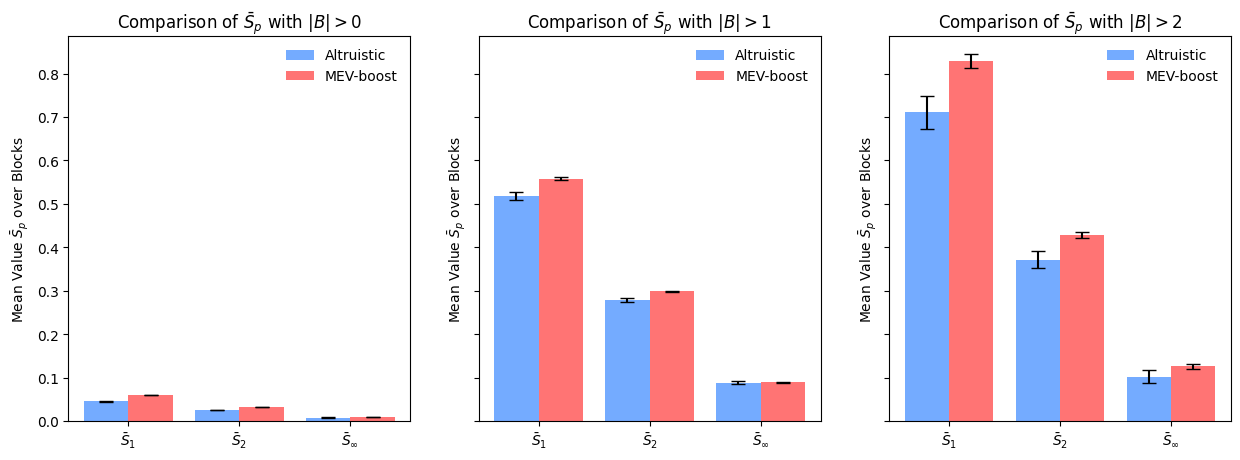

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

plot_between_group_comp(
    df_metric_agg, ax1, title="Comparison of $\\bar{S}_p$ with $|B| > 0$"
)
plot_between_group_comp(df_metric_agg_1, ax2, title="Comparison of $\\bar{S}_p$ with $|B| > 1$")
plot_between_group_comp(df_metric_agg_2, ax3, title="Comparison of $\\bar{S}_p$ with $|B| > 2$")

## Application of the Metric

### Between-group comparison


metric_l1 t-statistic: 4.109, p-value: 4.030921e-05
metric_l2 t-statistic: 3.690, p-value: 2.265030e-04
metric_linf t-statistic: 0.311, p-value: 7.559380e-01


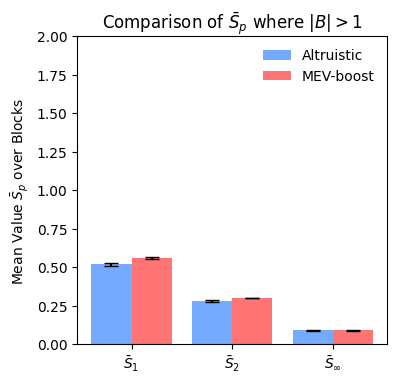

In [29]:
# Plotting for the paper
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_ylim(0, 2)
plot_between_group_comp(
    df_metric_agg_1, ax, title="Comparison of $\\bar{S}_p$ where $|B| > 1$"
)

# Save plot
if save_plots:
    fig.tight_layout()
    fig.savefig(
        str(plot_base_path / "empirical" / f"mev_boost_vs_altruistic>1{plot_file_type}")
    )

metric_l1 t-statistic: 2.902, p-value: 3.902578e-03
metric_l2 t-statistic: 2.709, p-value: 7.023219e-03
metric_linf t-statistic: 1.454, p-value: 1.467409e-01


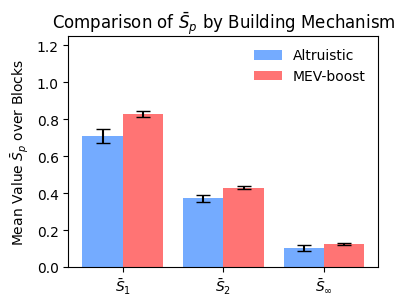

In [30]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_ylim(0, 1.25)
plot_between_group_comp(
    df_metric_agg_2, ax, title="Comparison of $\\bar{S}_p$ by Building Mechanism"
)

# Save plot
if save_plots:
    fig.tight_layout()
    fig.savefig(
        str(
            plot_base_path
            / "empirical"
            / f"mev_boost_vs_altruistic>2_short{plot_file_type}"
        )
    )

metric_l1 t-statistic: 2.902, p-value: 3.902578e-03
metric_l2 t-statistic: 2.709, p-value: 7.023219e-03
metric_linf t-statistic: 1.454, p-value: 1.467409e-01


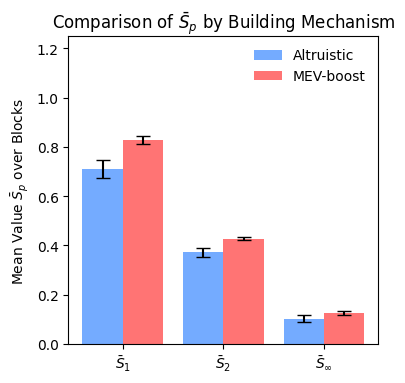

In [31]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_ylim(0, 1.25)
plot_between_group_comp(
    df_metric_agg_2, ax, title="Comparison of $\\bar{S}_p$ by Building Mechanism"
)

# Save plot
if save_plots:
    fig.tight_layout()
    fig.savefig(
        str(plot_base_path / "empirical" / f"mev_boost_vs_altruistic>2{plot_file_type}")
    )

metric_l1 t-statistic: 1.550, p-value: 1.212063e-01
metric_l2 t-statistic: 1.231, p-value: 2.183185e-01
metric_linf t-statistic: -0.838, p-value: 4.022109e-01


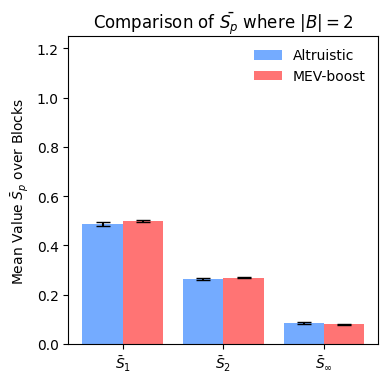

In [32]:
fig, ax = plt.subplots(figsize=(4, 4))

df_metric_agg_is_2 = (
    df_metric_1[df_metric_1.num_transactions == 2]
    .groupby("block_number")
    .agg(
        {
            "metric_l1": "sum",
            "metric_l2": "sum",
            "metric_linf": "sum",
            "mev_boost": "first",
        }
    )
)

ax.set_ylim(0, 1.25)
plot_between_group_comp(
    df_metric_agg_is_2, ax, title="Comparison of $\\bar{S_p}$ where $|B| = 2$"
)

# Save plot
if save_plots:
    fig.tight_layout()
    fig.savefig(
        str(plot_base_path / "empirical" / f"mev_boost_vs_altruistic=2{plot_file_type}")
    )

## Plot some example price trajectories


TypeError: can only concatenate list (not "str") to list

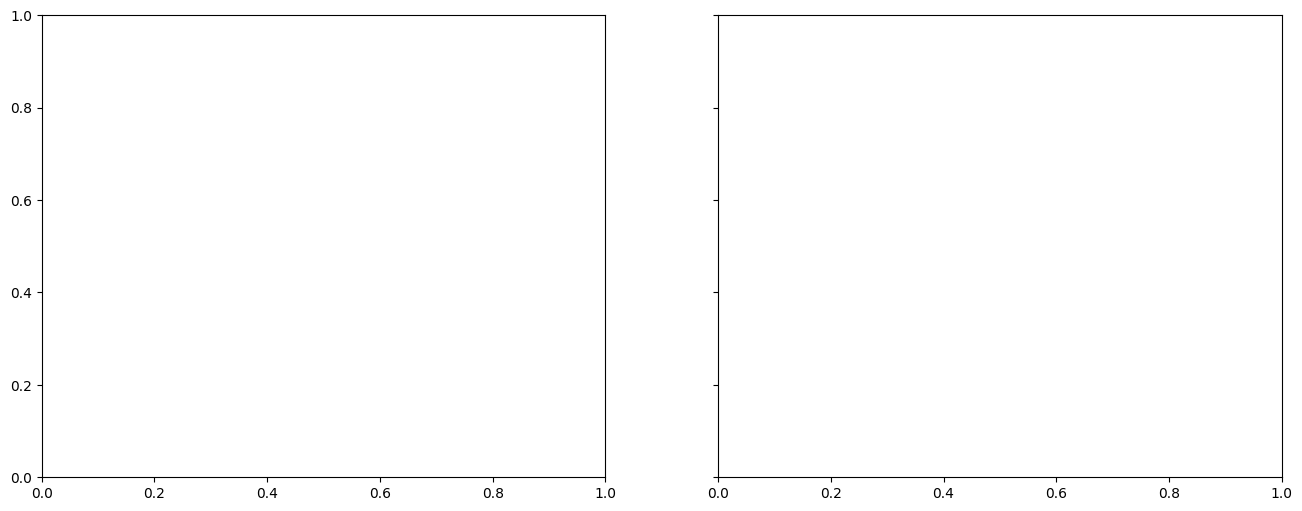

In [33]:
bar_col = bar_cols[1]

for i, row in (
    df_metric[(df_metric.n_buys > 1) & (df_metric.n_sells > 1)].sample(n=5).iterrows()
):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    realized_prices = [row.baseline_price] + row.realized_prices
    heuristic_prices = [row.baseline_price] + row.volume_heur_prices
    ax1.plot(realized_prices, label="Realized prices", color=bar_col)
    ax2.plot(heuristic_prices, label="Heuristic prices", color=bar_col)

    # Add baseline price
    ax1.axhline(
        row.baseline_price, color="black", linestyle="--", label="Baseline price"
    )
    ax2.axhline(
        row.baseline_price, color="black", linestyle="--", label="Baseline price"
    )

    ax1.set_title("Realized prices")
    ax2.set_title("Heuristic prices")

    ax1.set_ylabel("Price")
    ax1.set_xlabel("Swap number")
    ax2.set_xlabel("Swap number")

    # Create custom legend for ax1 (Realized Metrics)
    realized_legend_elements = [
        Line2D([0], [0], label="Realized prices", color=bar_col),
        Line2D([0], [0], color="white", label=f"l1: {row.realized_l1:.2e}"),
        Line2D([0], [0], color="white", label=f"l2: {row.realized_l2:.2e}"),
        Line2D([0], [0], color="white", label=f"linf: {row.realized_linf:.2e}"),
    ]
    ax1.legend(handles=realized_legend_elements, title="Realized Metrics")

    # Create custom legend for ax2 (Heuristic Metrics)
    heuristic_legend_elements = [
        Line2D([0], [0], label="Heuristic prices", color=bar_col),
        Line2D([0], [0], color="white", label=f"l1: {row.volume_heur_l1:.2e}"),
        Line2D([0], [0], color="white", label=f"l2: {row.volume_heur_l2:.2e}"),
        Line2D([0], [0], color="white", label=f"linf: {row.volume_heur_linf:.2e}"),
    ]
    ax2.legend(handles=heuristic_legend_elements, title="Heuristic Metrics")

    # Add swap labels for realized prices
    swap_labels = row.realized_order
    for j in range(len(swap_labels)):
        ax1.text(
            j + 0.5,
            (realized_prices[j] + realized_prices[j + 1]) / 2,
            swap_labels[j],
            ha="center",
        )

    # Add swap labels for heuristic prices
    swap_labels = row.volume_heur_order
    for j in range(len(swap_labels)):
        ax2.text(
            j + 0.5,
            (heuristic_prices[j] + heuristic_prices[j + 1]) / 2,
            swap_labels[j],
            ha="center",
        )

    fig.subplots_adjust(top=0.85)
    fig.suptitle(
        f"Realized vs. Heuristic Order\nPool: {row.pool_address}, Block: {row.block_number},Swapcount: {row.num_transactions}",
        fontsize=16,
    )
    print(
        f"Pool: {row.pool_address}, Block: {row.block_number}, Swapcount: {row.num_transactions}"
    )

In [34]:
# Create separate plots for:
# Pool: 0x4c1c69be20fadee2f3e7883f1c618be2df828e9c, Block: 17275081,Swapcount: 5
# Pool: 0xd8de6af55f618a7bc69835d55ddc6582220c36c0, Block: 16528093, Swapcount: 5
swap = df_metric[
    (df_metric.pool_address == "0xd8de6af55f618a7bc69835d55ddc6582220c36c0")
    & (df_metric.block_number == 16528093)
].iloc[0]
fig, ax = plt.subplots(figsize=(6, 4))

realized_prices = [swap.baseline_price] + swap.realized_prices
ax.plot(realized_prices, label="Realized prices", color=bar_col)

# Add baseline price
ax.axhline(swap.baseline_price, color="black", linestyle="--", label="Baseline price")

ax.set_title("Realized prices")

ax.set_ylabel("Price")
ax.set_xlabel("Swap number")

# Create custom legend for ax (Realized Metrics)
realized_legend_elements = [
    Line2D([0], [0], label="Realized prices", color=bar_col),
    Line2D([0], [0], color="white", label=f"l1: {swap.realized_l1:.2e}"),
    Line2D([0], [0], color="white", label=f"l2: {swap.realized_l2:.2e}"),
    Line2D([0], [0], color="white", label=f"linf: {swap.realized_linf:.2e}"),
]
ax.legend(handles=realized_legend_elements, title="Realized Metrics")


# Add swap labels for realized prices
swap_labels = swap.realized_order
for j in range(len(swap_labels)):
    ax.text(
        j + 0.5,
        (realized_prices[j] + realized_prices[j + 1]) / 2,
        swap_labels[j],
        ha="center",
    )

# Save plot
if save_plots:
    fig.tight_layout()
    fig.savefig(str(plot_base_path / "heuristic" / f"realized_order{plot_file_type}"))

IndexError: single positional indexer is out-of-bounds

NameError: name 'swap' is not defined

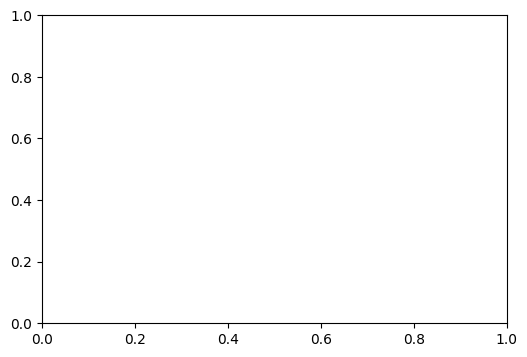

In [35]:
fig, ax = plt.subplots(figsize=(6, 4))

heuristic_prices = [swap.baseline_price] + swap.volume_heur_prices

ax.plot(heuristic_prices, label="Heuristic prices", color=bar_col)
ax.axhline(swap.baseline_price, color="black", linestyle="--", label="Baseline price")

ax.set_title("Heuristic prices")
ax.set_xlabel("Swap number")

# Create custom legend for ax (Heuristic Metrics)
heuristic_legend_elements = [
    Line2D([0], [0], label="Heuristic prices", color=bar_col),
    Line2D([0], [0], color="white", label=f"l1: {swap.volume_heur_l1:.2e}"),
    Line2D([0], [0], color="white", label=f"l2: {swap.volume_heur_l2:.2e}"),
    Line2D([0], [0], color="white", label=f"linf: {swap.volume_heur_linf:.2e}"),
]
ax.legend(handles=heuristic_legend_elements, title="Heuristic Metrics")

# Add swap labels for heuristic prices
swap_labels = swap.volume_heur_order
for j in range(len(swap_labels)):
    ax.text(
        j + 0.5,
        (heuristic_prices[j] + heuristic_prices[j + 1]) / 2,
        swap_labels[j],
        ha="center",
    )

# Save plot
if save_plots:
    fig.tight_layout()
    fig.savefig(str(plot_base_path / "heuristic" / f"heuristic_order{plot_file_type}"))

## How many samples are needed to get a good estimate of the metric?


In [36]:
def plot_with_error(ax, n_samples, means, errors, color, label):
    ax.plot(n_samples, means, color=color, label=label)
    ax.fill_between(n_samples, means - errors, means + errors, alpha=0.2, color=color)


def plot_comparison(
    ax, n_samples, altruistic_means, altruistic_errors, mev_means, mev_errors, z
):
    std_err_str = f"$\\pm {z} \\times \\sigma_{{\\mu}}$"
    plot_with_error(
        ax,
        n_samples,
        altruistic_means,
        altruistic_errors * z,
        bar_cols[0],
        f"Altruistic {std_err_str}",
    )
    plot_with_error(
        ax,
        n_samples,
        mev_means,
        mev_errors * z,
        bar_cols[1],
        f"MEV-boost {std_err_str}",
    )

    ax.set_xlabel("Number of blocks observed")
    ax.set_ylabel("Mean $\\bar{S}_{\\infty}$ metric")
    ax.set_title(
        f"Mean $\\bar{{S}}_{{\\infty}}$ and ${z}\\times SE$ vs. number of blocks observed"
    )
    ax.legend(frameon=False)

In [39]:
metric = "metric_linf"

n_samples = list(range(2, 400))
grouped_data = [
    df_metric_agg_2.groupby("mev_boost").sample(n=i // 2, replace=True, random_state=69)
    for i in tqdm(n_samples, desc="Sampling")
]

print("Calculate the means and errors for altruistic")
altruistic_means, altruistic_errors = zip(
    *[
        (
            g.groupby("mev_boost")[metric].mean()[False],
            g.groupby("mev_boost")[metric].sem()[False],
        )
        for g in grouped_data
    ]
)

print("Calculate the means and errors for MEV-boost")
mev_means, mev_errors = zip(
    *[
        (
            g.groupby("mev_boost")[metric].mean()[True],
            g.groupby("mev_boost")[metric].sem()[True],
        )
        for g in grouped_data
    ]
)

altruistic_means, altruistic_errors = np.array(altruistic_means), np.array(
    altruistic_errors
)
mev_means, mev_errors = np.array(mev_means), np.array(mev_errors)

Sampling:   0%|          | 0/398 [00:00<?, ?it/s]

Sampling: 100%|██████████| 398/398 [00:00<00:00, 1312.32it/s]


Calculate the means and errors for altruistic
Calculate the means and errors for MEV-boost


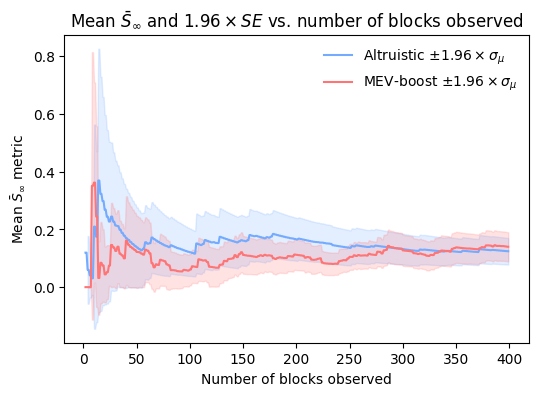

In [40]:
fig, ax = plt.subplots(figsize=(6, 4))
plot_comparison(
    ax, n_samples, altruistic_means, altruistic_errors, mev_means, mev_errors, 1.96
)

In [41]:
def single_run(run, df, metric, n_samples):
    grouped_data = [
        df.groupby("mev_boost").sample(n=i // 2, replace=True, random_state=69 + run)
        for i in n_samples
    ]

    altruistic_means, altruistic_errors = zip(
        *[
            (
                g.groupby("mev_boost")[metric].mean()[False],
                g.groupby("mev_boost")[metric].sem()[False],
            )
            for g in grouped_data
        ]
    )
    mev_means, mev_errors = zip(
        *[
            (
                g.groupby("mev_boost")[metric].mean()[True],
                g.groupby("mev_boost")[metric].sem()[True],
            )
            for g in grouped_data
        ]
    )
    return altruistic_means, altruistic_errors, mev_means, mev_errors


def run_experiment(df, metric, max_samples, n_runs=50):
    n_samples = list(range(2, max_samples))

    all_altruistic_means = np.zeros((n_runs, len(n_samples)))
    all_altruistic_errors = np.zeros((n_runs, len(n_samples)))
    all_mev_means = np.zeros((n_runs, len(n_samples)))
    all_mev_errors = np.zeros((n_runs, len(n_samples)))

    with ThreadPoolExecutor() as executor:
        results = list(
            tqdm(
                executor.map(
                    single_run,
                    range(n_runs),
                    [df] * n_runs,
                    [metric] * n_runs,
                    [n_samples] * n_runs,
                ),
                total=n_runs,
            )
        )

    for i, (altruistic_means, altruistic_errors, mev_means, mev_errors) in enumerate(
        results
    ):
        all_altruistic_means[i, :] = altruistic_means
        all_altruistic_errors[i, :] = altruistic_errors
        all_mev_means[i, :] = mev_means
        all_mev_errors[i, :] = mev_errors

    avg_altruistic_means = np.mean(all_altruistic_means, axis=0)
    avg_altruistic_errors = np.mean(all_altruistic_errors, axis=0)
    avg_mev_means = np.mean(all_mev_means, axis=0)
    avg_mev_errors = np.mean(all_mev_errors, axis=0)

    return avg_altruistic_means, avg_altruistic_errors, avg_mev_means, avg_mev_errors


avg_altruistic_means, avg_altruistic_errors, avg_mev_means, avg_mev_errors = (
    run_experiment(df_metric_agg_2, metric, 400, 50)
)

100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


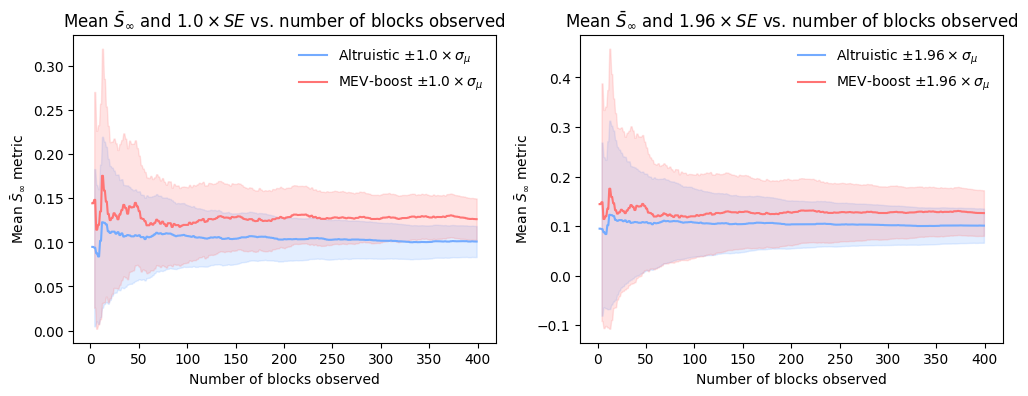

In [42]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
plot_comparison(
    ax1,
    n_samples,
    avg_altruistic_means,
    avg_altruistic_errors,
    avg_mev_means,
    avg_mev_errors,
    z=1.0,
)
plot_comparison(
    ax2,
    n_samples,
    avg_altruistic_means,
    avg_altruistic_errors,
    avg_mev_means,
    avg_mev_errors,
    z=1.96,
)

# Save plot
if save_plots:
    fig.tight_layout()
    fig.savefig(str(plot_base_path / "empirical" / f"sem_per_sample{plot_file_type}"))

## Can we meaningfully distinguish different builders and relays?


In [44]:
# Get a mapping from block number to builder
block_builders = pd.read_parquet("/data/scratch/ankile/surveillance-metric-2/data_original/mev-boost/openethdata_eth_data_clean.parquet")
block_builders = block_builders[["block_number", "builder", "relay"]]

block_builders.head()

,block_number,builder,relay
0,15537940,Flashbots,flashbots
1,15537948,Flashbots,flashbots
2,15537978,Flashbots,flashbots
3,15538064,Flashbots,flashbots
4,15538094,Flashbots,flashbots


In [45]:
# Augment the df_metric_agg_2 DataFrame with the builder
metric_2_builder_relay = df_metric_agg_2.merge(
    block_builders, on="block_number", how="left"
)
metric_2_builder_relay.builder = metric_2_builder_relay.builder.fillna("Altruistic")
metric_2_builder_relay.relay = metric_2_builder_relay.relay.fillna("Altruistic")

metric_2_builder_relay.head()

,block_number,metric_l1,metric_l2,metric_linf,mev_boost,builder,relay
0,15538020,1.274787,0.588839,1.394326e-02,False,Altruistic,Altruistic
1,15539005,1.593657,0.628515,4.798384e-13,True,Flashbots,flashbots
2,15539144,1.072143,0.731531,3.577947e-01,True,Flashbots,flashbots
3,15539276,0.696245,0.370122,1.614965e-02,True,Flashbots,flashbots
4,15539723,0.211706,0.034400,1.428156e-03,False,Altruistic,Altruistic


### Let's start by looking at builders


In [46]:
# Map the builder names to something more readable
name_mapping = {
    "Gambit Labs (https://gmbit.co)": "gmbit.co",
    "BuildAI (https://buildai.net)": "buildai.net",
    "https://edennetwork.io": "edennetwork.io",
    "viva ultrasound&agnostic by 0x69": "Viva Ultrasound",
    "0x83bee51799e65130296f5d60ce7d78119578db6045c3c3631980514abae0be0f9b65fe82eb0c9a79d6d99030112c874c": "0x83bee51799",
    "https://eth-builder.com": "eth-builder.com",
}
metric_2_builder_relay.builder = metric_2_builder_relay.builder.replace(name_mapping)

metric_2_builder_relay.head()

,block_number,metric_l1,metric_l2,metric_linf,mev_boost,builder,relay
0,15538020,1.274787,0.588839,1.394326e-02,False,Altruistic,Altruistic
1,15539005,1.593657,0.628515,4.798384e-13,True,Flashbots,flashbots
2,15539144,1.072143,0.731531,3.577947e-01,True,Flashbots,flashbots
3,15539276,0.696245,0.370122,1.614965e-02,True,Flashbots,flashbots
4,15539723,0.211706,0.034400,1.428156e-03,False,Altruistic,Altruistic


In [47]:
def get_aggregated_metrics(df, groupby, sort_by, n_samples=30):
    df_agg = df.groupby([groupby]).agg(
        {
            "metric_l1": "mean",
            "metric_l2": "mean",
            "metric_linf": "mean",
            "mev_boost": "first",
            "block_number": "count",
        }
    )

    # Add the standard error for the three metrics
    df_agg["metric_l1_sem"] = df.groupby([groupby])["metric_l1"].sem()
    df_agg["metric_l2_sem"] = df.groupby([groupby])["metric_l2"].sem()
    df_agg["metric_linf_sem"] = df.groupby([groupby])["metric_linf"].sem()

    df_agg = df_agg.sort_values(by=sort_by, ascending=False).reset_index()
    df_agg = df_agg[df_agg.block_number >= n_samples]

    return df_agg

In [48]:
metric_2_builders_agg = get_aggregated_metrics(
    metric_2_builder_relay, "builder", "metric_linf", n_samples=50
)

metric_2_builders_agg.head()

,builder,metric_l1,metric_l2,metric_linf,mev_boost,block_number,metric_l1_sem,metric_l2_sem,metric_linf_sem
6,edennetwork.io,0.982558,0.501627,0.189809,True,56,0.114738,0.053196,0.053504
8,builder0x69,0.817224,0.436719,0.150954,True,700,0.029435,0.015339,0.014413
10,beaverbuild.org,0.855641,0.437304,0.132304,True,480,0.036285,0.018067,0.015484
12,BloXroute,0.845468,0.437027,0.115275,True,204,0.051347,0.025158,0.020992
14,Flashbots,0.832244,0.423216,0.110969,True,905,0.027289,0.013209,0.010798


#### Look at the top 10 builders in terms of number of blocks (descending order)


In [49]:
metric_2_builders_agg.sort_values(by="block_number", ascending=False).head(n=10)

,builder,metric_l1,metric_l2,metric_linf,mev_boost,block_number,metric_l1_sem,metric_l2_sem,metric_linf_sem
14,Flashbots,0.832244,0.423216,0.110969,True,905,0.027289,0.013209,0.010798
8,builder0x69,0.817224,0.436719,0.150954,True,700,0.029435,0.015339,0.014413
10,beaverbuild.org,0.855641,0.437304,0.132304,True,480,0.036285,0.018067,0.015484
15,Altruistic,0.710887,0.371550,0.102518,False,305,0.037373,0.019389,0.014523
12,BloXroute,0.845468,0.437027,0.115275,True,204,0.051347,0.025158,0.020992
16,Geth Go,0.713943,0.375731,0.098426,True,95,0.056935,0.030329,0.025163
6,edennetwork.io,0.982558,0.501627,0.189809,True,56,0.114738,0.053196,0.053504


#### Look at the top 10 builders in terms of number of blocks (ascending order)


In [50]:
metric_2_builders_agg.sort_values(by="block_number", ascending=True).head(n=20)

,builder,metric_l1,metric_l2,metric_linf,mev_boost,block_number,metric_l1_sem,metric_l2_sem,metric_linf_sem
6,edennetwork.io,0.982558,0.501627,0.189809,True,56,0.114738,0.053196,0.053504
16,Geth Go,0.713943,0.375731,0.098426,True,95,0.056935,0.030329,0.025163
12,BloXroute,0.845468,0.437027,0.115275,True,204,0.051347,0.025158,0.020992
15,Altruistic,0.710887,0.371550,0.102518,False,305,0.037373,0.019389,0.014523
10,beaverbuild.org,0.855641,0.437304,0.132304,True,480,0.036285,0.018067,0.015484
8,builder0x69,0.817224,0.436719,0.150954,True,700,0.029435,0.015339,0.014413
14,Flashbots,0.832244,0.423216,0.110969,True,905,0.027289,0.013209,0.010798


In [51]:
metric_2_builders_agg.shape

(7, 9)

In [52]:
from textwrap import wrap


def plot_top_group(ax, df, group, metric, n, bar_cols):
    df = df.sort_values(by=metric, ascending=False)
    df_altruistic = df[df[group] == "Altruistic"]
    df_others = df[df[group] != "Altruistic"]
    if n != -1:
        df_others = df_others.head(n - 1)

    df_final = pd.concat([df_others, df_altruistic]).sort_values(
        by=metric, ascending=True
    )

    custom_palette = [
        bar_cols[0] if grouping == "Altruistic" else bar_cols[1]
        for grouping in df_final[group]
    ]
    bars = ax.barh(
        y=df_final[group],
        width=df_final[metric],
        color=custom_palette,
        xerr=df_final[f"{metric}_sem"],
        height=0.9,
    )

    ax.set_title(
        f"Top {n if n != -1 else df_final.shape[0]} {group}s by {metrics_latex[metrics.index(metric)]}",
        fontsize=16,
    )
    ax.set_ylabel("")
    ax.set_xlabel(metrics_latex[metrics.index(metric)], fontsize=12)

    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

    # Increase font size and wrap text
    wrapped_labels = [
        "\n".join(wrap(label.get_text(), 12)) for label in ax.get_yticklabels()
    ]
    ax.set_yticklabels(wrapped_labels, fontsize=12)

/tmp/ipykernel_1882835/3233991900.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(wrapped_labels, fontsize=12)
/tmp/ipykernel_1882835/3233991900.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(wrapped_labels, fontsize=12)
/tmp/ipykernel_1882835/3233991900.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(wrapped_labels, fontsize=12)


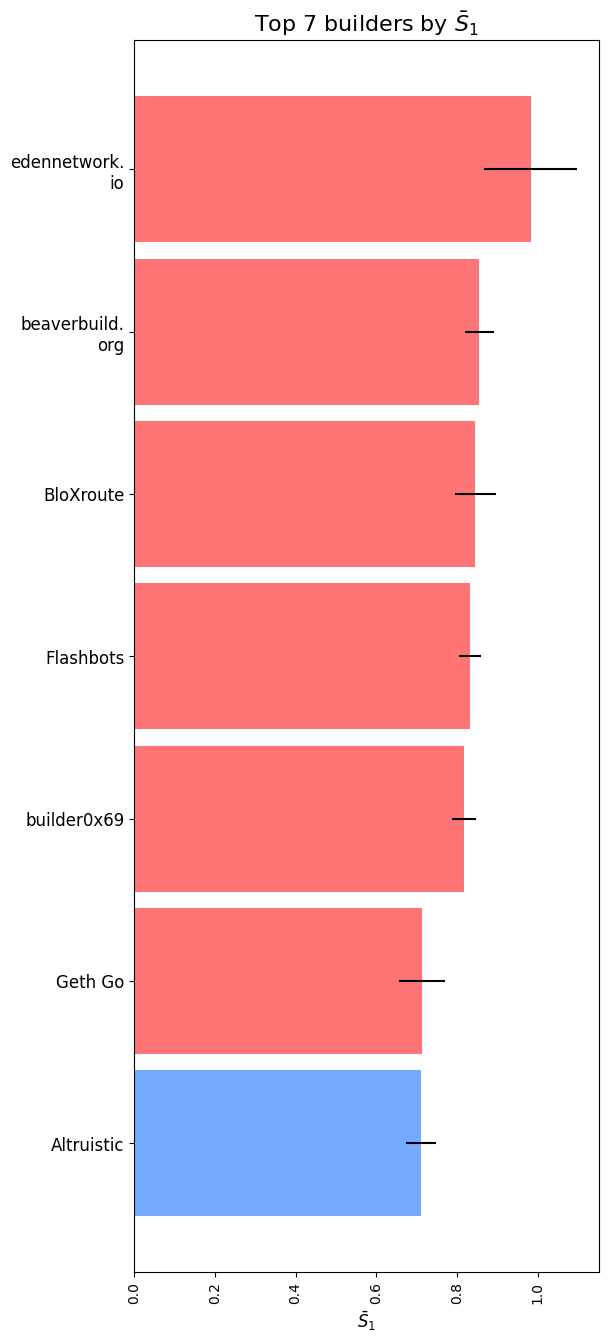

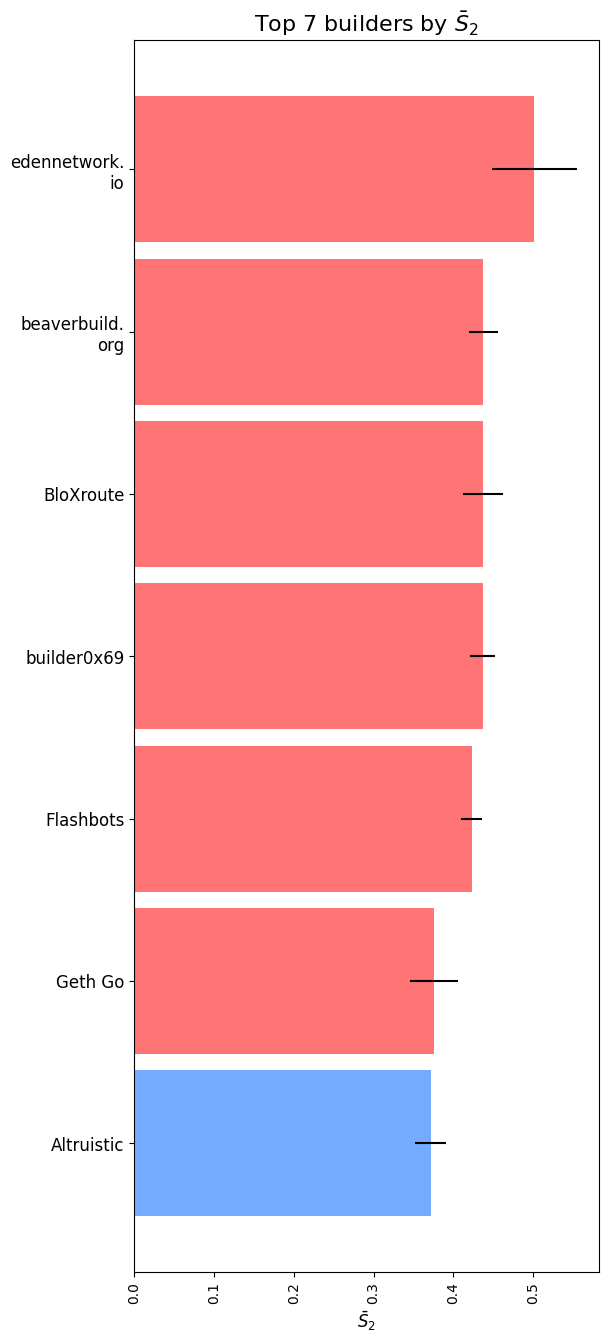

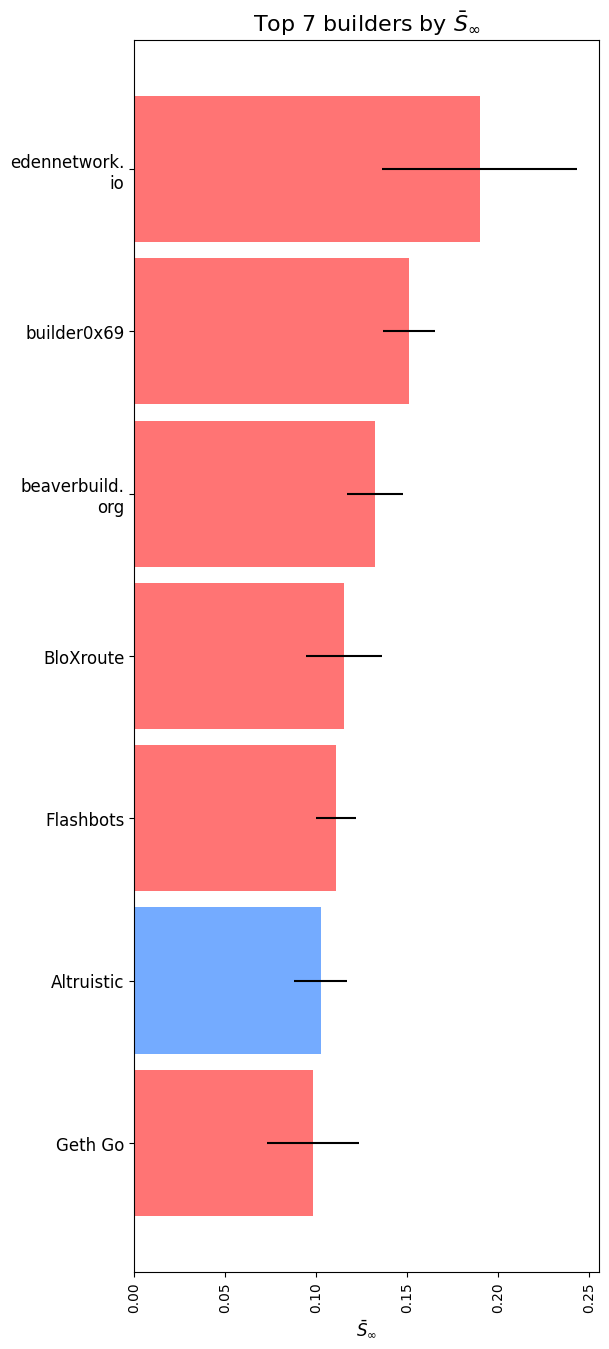

In [53]:
for metric in metrics:
    fig, ax = plt.subplots(figsize=(6, 16))
    plot_top_group(ax, metric_2_builders_agg, "builder", metric, -1, bar_cols)

    # Save plot
    if save_plots:
        fig.tight_layout()
        fig.savefig(
            str(plot_base_path / "empirical" / f"top_builders_{metric}{plot_file_type}")
        )

### So what about relays?


In [54]:
metric_2_relays_agg = get_aggregated_metrics(
    metric_2_builder_relay, "relay", "metric_linf", n_samples=20
)

metric_2_relays_agg

,relay,metric_l1,metric_l2,metric_linf,mev_boost,block_number,metric_l1_sem,metric_l2_sem,metric_linf_sem
0,ultrasound,0.784683,0.470862,0.248211,True,71,0.084609,0.049829,0.051375
2,eden,0.954003,0.493466,0.197193,True,61,0.109916,0.052877,0.053026
3,agnostic Gnosis,0.579681,0.349576,0.184174,True,65,0.064927,0.041575,0.047264
4,bloxroute (ethical),0.715860,0.426311,0.183104,True,22,0.151093,0.091452,0.072442
5,blocknative,0.763354,0.437442,0.179829,True,38,0.136973,0.073767,0.053888
6,bloxroute (regulated),0.823625,0.444108,0.175123,True,45,0.085542,0.040042,0.044290
7,bloxroute (max profit),0.889064,0.450681,0.125286,True,306,0.047304,0.022047,0.017324
8,flashbots,0.827153,0.426138,0.121849,True,1990,0.017820,0.008933,0.007716
9,Altruistic,0.710887,0.371550,0.102518,False,305,0.037373,0.019389,0.014523


#### Look at the top 10 relays in terms of number of blocks (descending order)


In [55]:
metric_2_relays_agg.sort_values(by="block_number", ascending=False).head(n=10)

,relay,metric_l1,metric_l2,metric_linf,mev_boost,block_number,metric_l1_sem,metric_l2_sem,metric_linf_sem
8,flashbots,0.827153,0.426138,0.121849,True,1990,0.017820,0.008933,0.007716
7,bloxroute (max profit),0.889064,0.450681,0.125286,True,306,0.047304,0.022047,0.017324
9,Altruistic,0.710887,0.371550,0.102518,False,305,0.037373,0.019389,0.014523
0,ultrasound,0.784683,0.470862,0.248211,True,71,0.084609,0.049829,0.051375
3,agnostic Gnosis,0.579681,0.349576,0.184174,True,65,0.064927,0.041575,0.047264
2,eden,0.954003,0.493466,0.197193,True,61,0.109916,0.052877,0.053026
6,bloxroute (regulated),0.823625,0.444108,0.175123,True,45,0.085542,0.040042,0.044290
5,blocknative,0.763354,0.437442,0.179829,True,38,0.136973,0.073767,0.053888
4,bloxroute (ethical),0.715860,0.426311,0.183104,True,22,0.151093,0.091452,0.072442


#### Look at the top 10 relays in terms of number of blocks (ascending order)


In [56]:
metric_2_relays_agg.sort_values(by="block_number", ascending=True).head(n=10)

,relay,metric_l1,metric_l2,metric_linf,mev_boost,block_number,metric_l1_sem,metric_l2_sem,metric_linf_sem
4,bloxroute (ethical),0.715860,0.426311,0.183104,True,22,0.151093,0.091452,0.072442
5,blocknative,0.763354,0.437442,0.179829,True,38,0.136973,0.073767,0.053888
6,bloxroute (regulated),0.823625,0.444108,0.175123,True,45,0.085542,0.040042,0.044290
2,eden,0.954003,0.493466,0.197193,True,61,0.109916,0.052877,0.053026
3,agnostic Gnosis,0.579681,0.349576,0.184174,True,65,0.064927,0.041575,0.047264
0,ultrasound,0.784683,0.470862,0.248211,True,71,0.084609,0.049829,0.051375
9,Altruistic,0.710887,0.371550,0.102518,False,305,0.037373,0.019389,0.014523
7,bloxroute (max profit),0.889064,0.450681,0.125286,True,306,0.047304,0.022047,0.017324
8,flashbots,0.827153,0.426138,0.121849,True,1990,0.017820,0.008933,0.007716


/tmp/ipykernel_1882835/3233991900.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(wrapped_labels, fontsize=12)
/tmp/ipykernel_1882835/3233991900.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(wrapped_labels, fontsize=12)
/tmp/ipykernel_1882835/3233991900.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(wrapped_labels, fontsize=12)


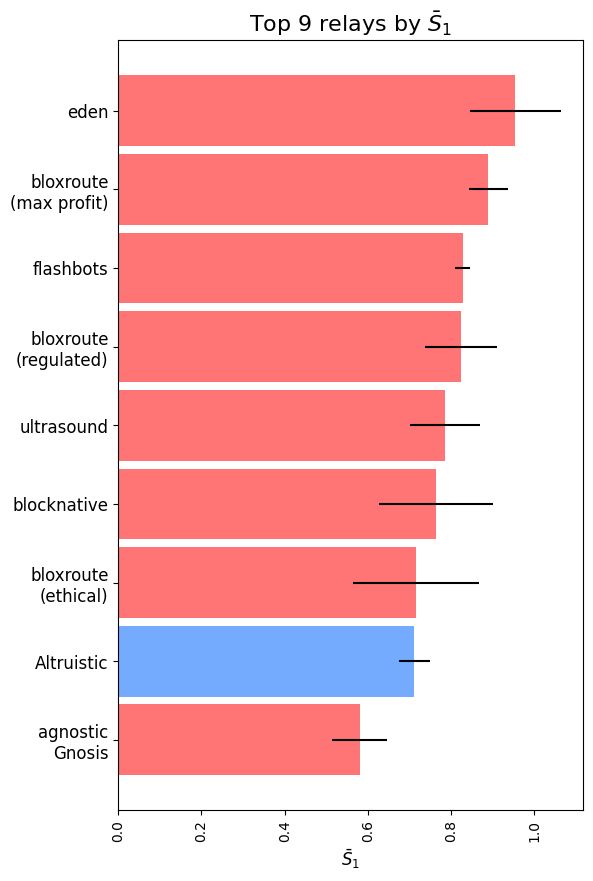

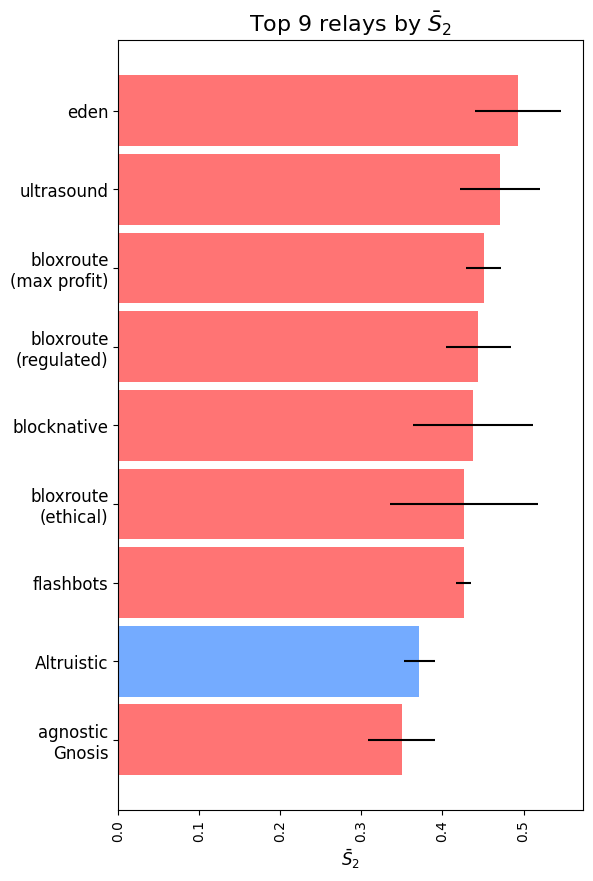

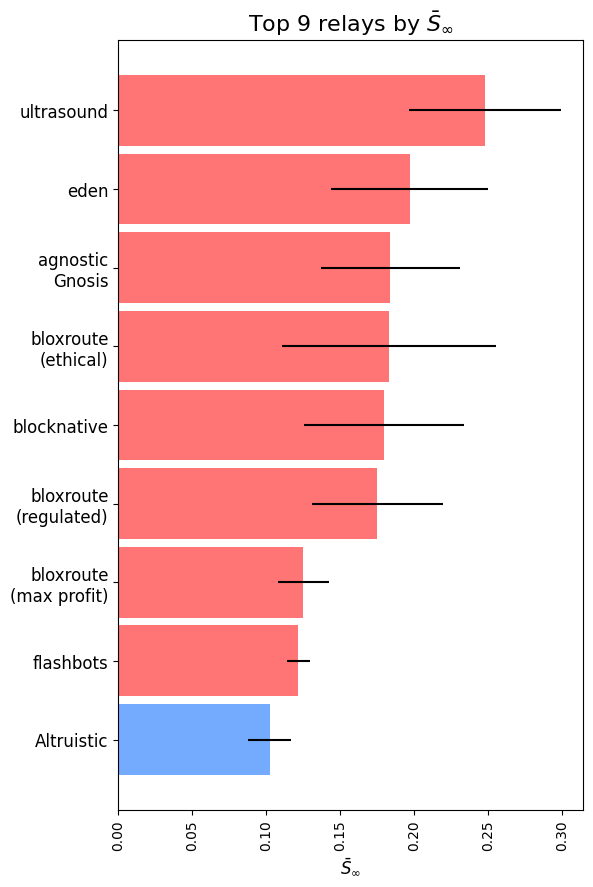

In [57]:
for metric in metrics:
    fig, ax = plt.subplots(figsize=(6, 10))
    plot_top_group(ax, metric_2_relays_agg, "relay", metric, -1, bar_cols)

    # Save plot
    if save_plots:
        fig.tight_layout()
        fig.savefig(
            str(plot_base_path / "empirical" / f"top_relays_{metric}{plot_file_type}")
        )

### Output the list of builders and relays

To look at the same set of entities in other analyses.


In [58]:
metric_2_builders_agg.builder.unique().tolist()

['edennetwork.io',
 'builder0x69',
 'beaverbuild.org',
 'BloXroute',
 'Flashbots',
 'Altruistic',
 'Geth Go']